Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Импорт

In [1]:
#Импорт библиотек
import os
import math
import time
import itertools 
import urllib.request
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
SEED=12345
from scipy import stats

In [2]:
#Импортнем DataScience класс
class DataScience:

    
    def sns_draw(self, data, parametr, bins=30):
        fig = plt.figure(figsize=(15, 6), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        ax_main = fig.add_subplot(grid[:-1, :-1])
        ax_right = fig.add_subplot(grid[:-1, -1])  
        sns.distplot(data[parametr], ax=ax_main)
        sns.boxplot(data[parametr], ax=ax_right)
        ax_right.grid(axis='y')
        ax_main.set(title='График '+parametr)
        ax_main.axvline(np.mean(data[parametr]),color='g', linestyle='--', label='Среднее')
        ax_main.axvline(np.median(data[parametr]),color='g', linestyle='-', label='Медиана')
        ax_main.legend()
        fig.show()
    
    
    def plot_feature_importance(self,importance,names,model_type):

        feature_importance = np.array(importance)
        feature_names = np.array(names)

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

        #Define size of bar plot
        plt.figure(figsize=(10,8))
        #Plot Searborn bar chart
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        #Add chart labels
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')
        
    def fit(self,train_features, train_actuals):
        for name in models.keys():
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5)
            gscv.fit(train_features, train_actuals)
            train_predictions = gscv.predict(features_train)
            predictions = gscv.predict(features_test)
            result_list.append({
            'model': name,
            'train_mae_score': mean_absolute_error(target_train, train_predictions),
            'test_mae_score': mean_absolute_error(target_test, predictions),
            'best_params': gscv.best_params_
            })
            
    
    def dataset_info(self,data):
        data.info()
        display(data.head(10))
        display(data.describe())
        print('Количество дубликатов:', data.duplicated().sum())
    

            
ds = DataScience()

### Исследовательский анализ данных

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

#### `Data_arc` : Данные об электродах

In [4]:
ds.dataset_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество дубликатов: 0


Проблемы:
 - Аномальное значение реактивной мощности, необходимо будет это учесть
 - Переименовать столбцы для более удобного обращения
 - Поменять типы данных для столбцов, содержащих дату

Для начала переименовываю столбцы

In [5]:
data_arc.rename(columns={
    'Начало нагрева дугой': 'arc_heating_start', 
    'Конец нагрева дугой': 'arc_heating_end', 
    'Активная мощность': 'active_power', 
    'Реактивная мощность': 'reactive_power'}, inplace=True)

После привожу столбцы с датами к нужному типу

In [6]:
data_arc[['arc_heating_start','arc_heating_end']] = pd.to_datetime(
    data_arc[['arc_heating_start','arc_heating_end']].stack()).unstack()

In [7]:
data_arc = data_arc[data_arc['reactive_power']>0]

In [8]:
data_arc['key'].value_counts().median()

4.0

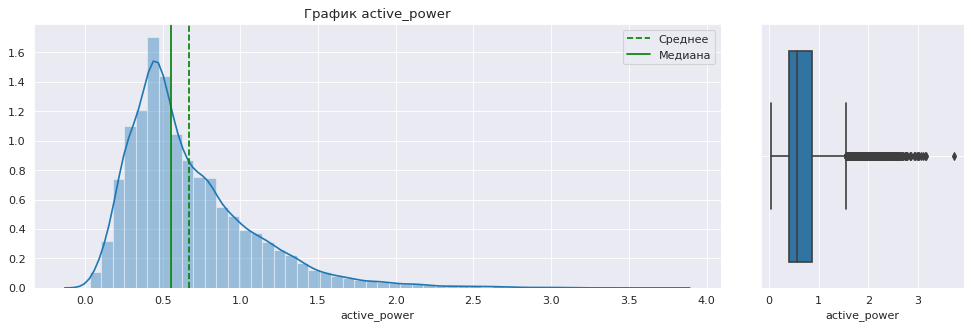

In [9]:
ds.sns_draw(data_arc, 'active_power')

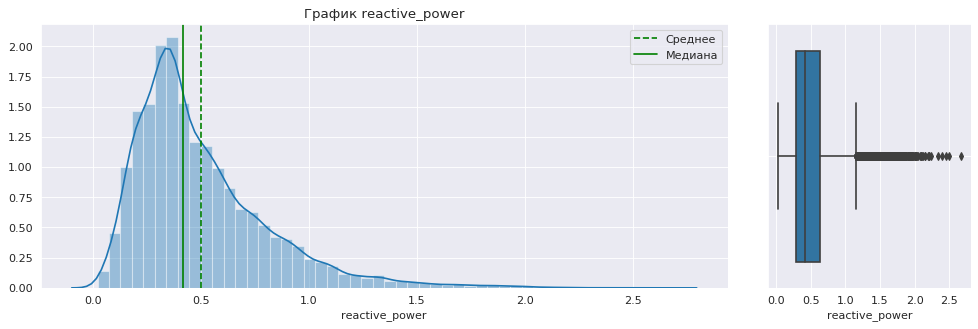

In [10]:
ds.sns_draw(data_arc, 'reactive_power')

Значения мощностей напоминают график нормального распределения с отклонением влево

Корреляция параметров active_power и reactive_power 0.9631819131519803


<Figure size 1440x720 with 0 Axes>

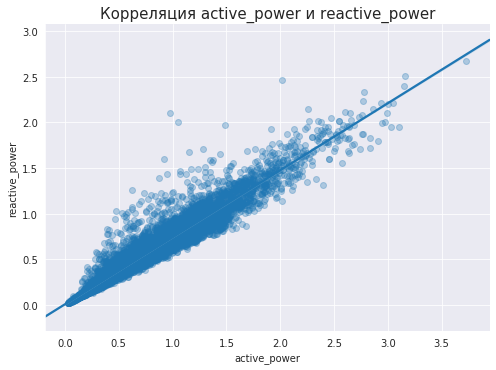

In [11]:
print('Корреляция параметров active_power и reactive_power', data_arc['active_power'].corr(data_arc['reactive_power']))
plt.figure(figsize=(20,10))
sns.lmplot(x='active_power', y='reactive_power',data=data_arc, scatter_kws={'alpha':0.3}, aspect=14/10)
plt.title('Корреляция active_power и reactive_power', fontsize=15)
plt.show();

Наблюдается сильная корелляция параметров, необходимо это предусмотреть, так как это может повлиять на качество модели

На основе значений мощностей можно расчитать значение полной мощности по формуле $$ S=\sqrt{P^2+Q^2} $$

In [12]:
def full_power(row):
    full_power = math.sqrt(row['active_power']**2 + row['active_power']**2)
    return full_power

In [13]:
data_arc['full_power'] = data_arc.apply(full_power, axis=1)

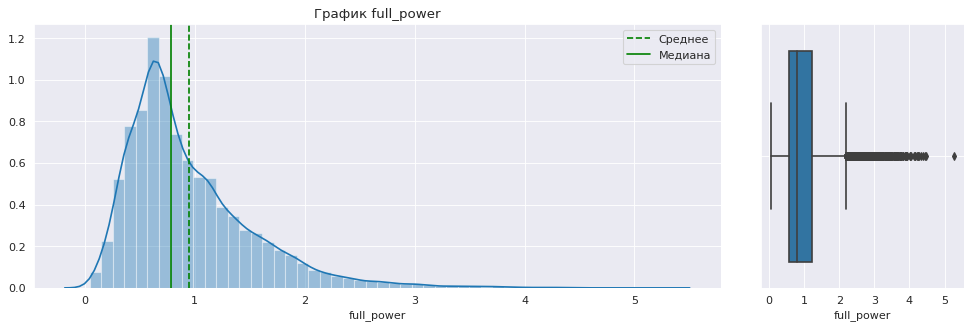

In [14]:
ds.sns_draw(data_arc, 'full_power')

#### `Data_Bulk` : Данные о подаче сыпучих материалов (объём);

In [15]:
ds.dataset_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество дубликатов: 0


- Типы данных указаны верно. Дубликаты отсутствуют.
- Наблюдается большое количество пропущенных значений в датасете. Это обусловленно логикой процесса

In [16]:
data_bulk.rename(str.lower, axis='columns', inplace=True)

In [17]:
data_bulk.columns = data_bulk.columns.str.replace(' ', '')

#### `Data_Bulk_time` - Данные о подаче сыпучих материалов (время);

In [18]:
ds.dataset_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество дубликатов: 0


- Наблюдается большое количество пропущенных значений в датасете
- В построении модели данный датасет не будет использоваться, данная информация избыточна

#### `Data_gas` - данные о продувке сплава газом;

In [19]:
ds.dataset_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество дубликатов: 0


Наблюдаются следующие проблемы:
- необходимо переименовать столбец для удобной работы

In [20]:
data_gas.rename(columns={'Газ 1': 'gas'}, inplace=True)

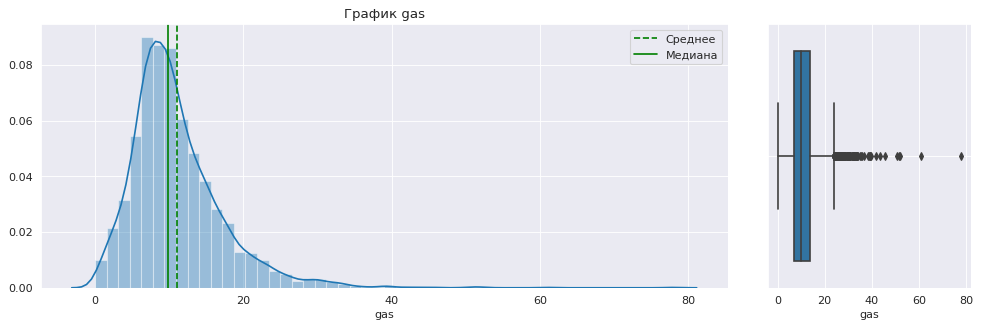

In [21]:
ds.sns_draw(data_gas, 'gas')

Распределние значений напоминает нормальное, с небольшим отклонением влево

#### `Data_temp` - Результаты измерения температуры;

In [22]:
ds.dataset_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество дубликатов: 0


Для этого датасета наблюдаются следующие проблемы:
- переименовать столбцы для более удобного обращения
- изменить тип данных для столбца с временем замера
- В данных по температуре присуствуют пропуски, необходимо решить их судьбу

In [23]:
data_temp.rename(columns={
    'Время замера': 'measurement_time', 
    'Температура': 'temperature'}, inplace=True)

In [24]:
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'])

In [25]:
data_temp[data_temp['temperature'].isnull()].head(10)

,key,measurement_time,temperature
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


- Так как пропущеное значение - целевой признак, то пропуски будут удалены
- Исправлен тип данных у признака measurement_time на datetime
- Дубликатов не имеется

#### `Data_Wire`  -  данные о проволочных материалах (объём);

In [26]:
ds.dataset_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество дубликатов: 0


Выводы по датасету:
- дубликаты отстутсвуют
- Присутствуют пропуски, обсловленные техникой процесса, пропуски будут заполнены нулями

In [27]:
data_wire.rename(str.lower, axis='columns', inplace=True)

In [28]:
data_wire.columns = data_wire.columns.str.replace(' ', '')

In [29]:
ds.dataset_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество дубликатов: 0


Датасет аналогичен data_bulk_time, использоваться не будет

## Выводы
1. Данные изучены, столбцы переименованы и приведены к нужным типам
2. Обнаружена корелляция параметров
3. Расчитан новый признак

## Предобработка данных

На основе данных о старте и конце времени нагрева можно вычислить новый признак: длительность нагрева

In [30]:
data_arc['arc_heating_time'] = data_arc['arc_heating_end'] - data_arc['arc_heating_start']
data_arc['arc_heating_time'] = data_arc['arc_heating_time'].dt.seconds

Так как после партии 2500 измерена температура только для старта, то эти данные нам не подходят, так как целевой признак - финальная температура. поэтому данны по этим партиям нужно удалить

In [31]:
data_temp = data_temp.query('key < 2500')
data_arc = data_arc.query('key < 2500')
data_bulk = data_bulk.query('key < 2500')
data_wire = data_wire.query('key < 2500')

Далее необходимо расчитать количество итерраций нагрева

In [32]:
data_arc_c = data_arc.groupby(by = 'key', as_index = False).count()[['key', 'arc_heating_start']]
data_arc_c.columns = ['key', 'num_heating_iter']

Далее данные группируются по партиям

In [33]:
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()

Далее таблицы с количеством итерраций нагрева и данные о нагреве оеденяются по ключу

In [34]:
data_arc = data_arc.merge(data_arc_c, how = 'left', on = 'key')

Так как обнаружена корелляция между признаками мощности решено использовать только расчитаную полную мощность

In [35]:
data_arc = data_arc[['key', 'full_power', 'arc_heating_time', 'num_heating_iter']]

Далее строится график корелляций признаков

<Figure size 1080x720 with 0 Axes>

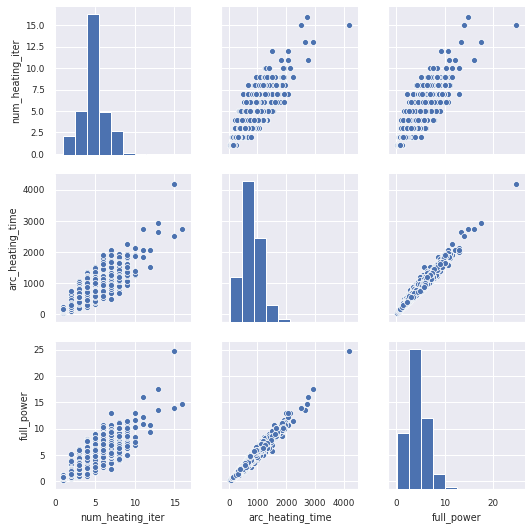

In [36]:
plt.figure(figsize=(15,10))
sns.set(font_scale=0.8)
sns.pairplot(data_arc[['num_heating_iter', 'arc_heating_time', 'full_power']], 
             kind="scatter")
plt.show();

А так же корелляция расчитывается в виде таблицы (что для меня удобнее)

In [37]:
data_arc[['full_power', 'arc_heating_time', 'num_heating_iter']].corr()

,full_power,arc_heating_time,num_heating_iter
full_power,1.000000,0.978192,0.754205
arc_heating_time,0.978192,1.000000,0.795958
num_heating_iter,0.754205,0.795958,1.000000


Как видно из таблицы присутствует корелляция между полной мощностью и временем нагрева дугой. поэтому принято решение удалить признак, отвечающий за время нагрева дуги

In [38]:
data_arc = data_arc[['key', 'full_power', 'num_heating_iter']]

Далее необходимо удалить пропуски в таблице data_temp и отсортируем по признаку measurement_time

In [39]:
data_temp = data_temp.dropna(subset=['temperature']).reset_index(drop=True)
data_temp = data_temp.sort_values(by=['measurement_time'])

Далее необходимо удалить те записи, в которых известно только одно измерение температуры

In [40]:
count = data_temp.groupby(by = 'key', as_index = False).count()
one = count[count['measurement_time'] == 1]['key'].tolist()
data_temp = data_temp.query('key not in @one')

Далее необходимо сгруппировать данные по первым и последним значениям температуры, так как нужно выделить целевой признак. в итоге из одного признака temperature получится два - стартовая и конечная (целевой признак)

In [41]:
data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'measurement_time1', 'measurement_time2', 'temperature1', 'temperature2']
data_temp = data_temp[['key', 'temperature1', 'temperature2']]

Далее все неободимые таблицы объеденяются по ключу в одну

In [42]:
data = (data_temp.merge(data_arc, how = 'left', on = 'key')
                 .merge(data_wire, how = 'left', on = 'key')
                 .merge(data_bulk, how = 'left', on = 'key')
                 .merge(data_gas, how = 'left', on = 'key')
       )

Все пропущенные значения заполняются нулями

In [43]:
data = data.fillna(0)

так как столбец key больше не нужен его можно удалить

In [44]:
data = data.drop(['key'], axis = 1)

In [45]:
data.head(5)

,temperature1,temperature2,full_power,num_heating_iter,wire1,wire2,wire3,wire4,wire5,wire6,...,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15,gas
0,1571.0,1613.0,6.898741,5,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,1581.0,1602.0,4.317026,4,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,1596.0,1599.0,3.572137,5,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,1601.0,1625.0,4.538565,4,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,1576.0,1602.0,4.733617,4,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


Для более удобного обращения столбцы с температурой переименовываются

In [46]:
data = data.rename(columns={'temperature1': 'start_temperature',
                            'temperature2': 'end_temperature'})

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 29 columns):
start_temperature    2475 non-null float64
end_temperature      2475 non-null float64
full_power           2475 non-null float64
num_heating_iter     2475 non-null int64
wire1                2475 non-null float64
wire2                2475 non-null float64
wire3                2475 non-null float64
wire4                2475 non-null float64
wire5                2475 non-null float64
wire6                2475 non-null float64
wire7                2475 non-null float64
wire8                2475 non-null float64
wire9                2475 non-null float64
bulk1                2475 non-null float64
bulk2                2475 non-null float64
bulk3                2475 non-null float64
bulk4                2475 non-null float64
bulk5                2475 non-null float64
bulk6                2475 non-null float64
bulk7                2475 non-null float64
bulk8                2475 non-null 

## Выводы
- Все таблицы предобработаны и оъеденены в один датасет
- Выделен целевой признак
- Найдена корелляция, от которой пришлось избавиться путем удаления параметра

## Обучение модели

Далее полученый датасет разбивается на тестовую и обучающую выборки в соотношении 30/70

In [48]:
train, test = train_test_split(data, test_size = .30, random_state = 12345)

In [49]:
print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выобрки:', test.shape)

Размер обучающей выборки: (1732, 29)
Размер тестовой выобрки: (743, 29)


создаются два набора для обучения

In [50]:
features_train = train.drop(['end_temperature'], axis = 1)
target_train = train['end_temperature']

и для теста

In [51]:
features_test = test.drop(['end_temperature'], axis = 1)
target_test = test['end_temperature']

Далее описываются используемые модели (по сравнению с планом добавлен XGBRegressor) и их гиперпараметры для кросс-валидации

In [52]:
models = {
    'CatBoostRegressor': CatBoostRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'XGBRegressor': xgboost.XGBRegressor(),
    'LinearRegression': LinearRegression()
}


params = {
    'CatBoostRegressor':{
          'loss_function':['MAE'],
          'n_estimators': np.arange(500, 700, 100),  
          'learning_rate': np.arange(0.08, 0.12, 0.02),
          'random_state':[12345],
          'depth': np.arange(3, 5)
    },        

    'LinearRegression':{
            'fit_intercept' : [True, False],
            'normalize':[True,False]
    },
    
    
    'LGBMRegressor': {
        'boosting_type': ['gbdt', 'dart'],
        'objective': ['regression'],
        'learning_rate': [0.01, 0.02, 0.03],
        'num_iterations':[500],
        'random_state': [12345], 
        'max_depth': np.arange(2, 5),
        'metric': ['mae']
        },

    
    'XGBRegressor': {
        'min_child_weight': [20,30],
        'gamma': [5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [10,20],
        'eval_metric' :['mae']
        }
}

Далее запукается кастомная функция для обучения

In [57]:
%%time
result_list = []
ds.fit(features_train, target_train)

0:	learn: 9.7894575	total: 48.3ms	remaining: 24.1s
1:	learn: 9.6168585	total: 49.5ms	remaining: 12.3s
2:	learn: 9.5592846	total: 50.5ms	remaining: 8.37s
3:	learn: 9.4013524	total: 59.9ms	remaining: 7.43s
4:	learn: 9.2742435	total: 62.8ms	remaining: 6.21s
5:	learn: 9.0825209	total: 64.6ms	remaining: 5.32s
6:	learn: 8.9709462	total: 65.6ms	remaining: 4.62s
7:	learn: 8.9285717	total: 66.6ms	remaining: 4.09s
8:	learn: 8.8194683	total: 73.5ms	remaining: 4.01s
9:	learn: 8.6843243	total: 104ms	remaining: 5.07s
10:	learn: 8.5950431	total: 105ms	remaining: 4.65s
11:	learn: 8.5058246	total: 106ms	remaining: 4.3s
12:	learn: 8.4401979	total: 107ms	remaining: 4s
13:	learn: 8.4066454	total: 108ms	remaining: 3.74s
14:	learn: 8.3257979	total: 109ms	remaining: 3.52s
15:	learn: 8.2938181	total: 110ms	remaining: 3.32s
16:	learn: 8.2153599	total: 111ms	remaining: 3.15s
17:	learn: 8.1500107	total: 112ms	remaining: 3s
18:	learn: 8.1040173	total: 113ms	remaining: 2.87s
19:	learn: 8.0063730	total: 114ms	remai

Все результаты обучения собируются в одну таблицу для оценки качества

In [58]:
results = pd.DataFrame(result_list, columns=['model','train_mae_score','test_mae_score','best_params'])
results.set_index("model", inplace = True)

In [59]:
results

,train_mae_score,test_mae_score,best_params
model,,,
CatBoostRegressor,4.552523,5.980933,"{'depth': 3, 'learning_rate': 0.08, 'loss_func..."
LGBMRegressor,4.400294,6.077841,"{'boosting_type': 'gbdt', 'learning_rate': 0.0..."
XGBRegressor,3.947707,6.099517,"{'colsample_bytree': 1.0, 'eval_metric': 'mae'..."
LinearRegression,7.892548,7.769591,"{'fit_intercept': True, 'normalize': True}"


Как можно заметить лучший результат на тесте показал CatBoostRegressor с приведенными выше гиперпараметрами

Далее создается модель с найденными гиперпараметрами для нахождения МАЕ на тестовой выборке

In [62]:
model = CatBoostRegressor(depth=3, 
                          learning_rate = 0.08, 
                          loss_function = 'MAE', 
                          n_estimators = 600, 
                          random_state = 12345,
                          verbose = 0)

model.fit(features_train,target_train)
predictions = model.predict(features_test)
print('MAE на тестовой выборке:', mean_absolute_error(predictions,target_test))

MAE на тестовой выборке: 5.980932949461419


Далее построен график для важности признаков 

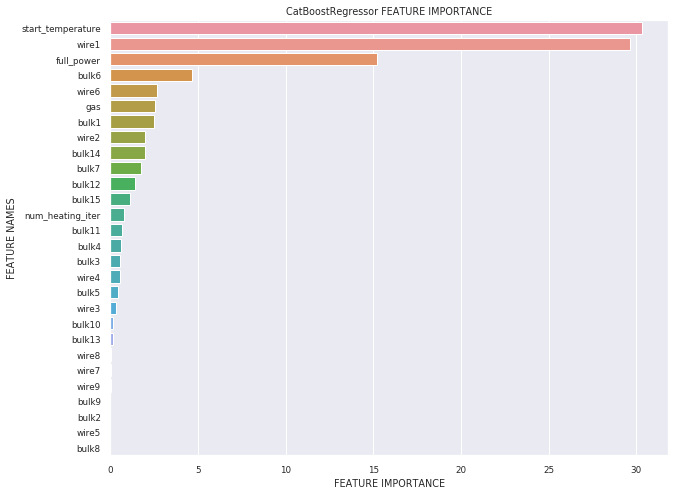

In [63]:
ds.plot_feature_importance(model.feature_importances_,features_test.columns,'CatBoostRegressor ')

## Выводы
- был проведен исследовательский анализ данных
- Были обработаны пропущенные значения, а также получилось избавиться от корелляции данных
- Добавленно несколько расетных признаков
- Для обучения использовали 4 модели : CatBoostRegressor, LightGBMRegressor, XGboostRegressor, LinearRegression
- Был проведен подбор оптимальных гиперпараметров
- Наилучший результат, полученный при помощи CatBoostRegressor показал резульат МАЕ на тестовой выборке равный **5.98**
- Выявлены наиболее важные параметры, а именно: start_temperature, wire1 и full_power

Так как Целью данного проeкта являлась энергоэффективность предприятия то логично сделать следующиий вывод: **Начальная температура нагрева влияет на конечную температуру**, соответственно управляя начальной температурой мы управляем всем процессом и можем настроить его на необходимую нам энергоэффективность. 
